# Fine-tuning FT-DETR on SCD dataset

# Setup

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q roboflow supervision
!pip install -q "albumentations>=1.4.5"
!pip install -q torchmetrics
from IPython.display import clear_output
clear_output()

In [10]:
import torch
import requests
import os
import json

import pandas as pd
import numpy as np
import supervision as sv
import albumentations as A

from PIL import Image
from pprint import pprint
from roboflow import Roboflow
from dataclasses import dataclass, replace
from google.colab import userdata
from torch.utils.data import Dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForObjectDetection,
    TrainingArguments,
    Trainer
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from matplotlib import pyplot as plt

In [3]:
path = '/content/drive/MyDrive/0_Projects/drone-warehouse/'
os.chdir(path)

# Dataset

In [4]:
image_directory_path = 'ft-scd-coco-dataset/train'
ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=image_directory_path,
    annotations_path=f"{image_directory_path}/annotations.coco.json",
)
image_directory_path = 'ft-scd-coco-dataset/val'

ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=image_directory_path,
    annotations_path=f"{image_directory_path}/annotations.coco.json",
)
image_directory_path = 'ft-scd-coco-dataset/test'
ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=image_directory_path,
    annotations_path=f"{image_directory_path}/annotations.coco.json",
)

print(f"Number of training images: {len(ds_train)}")
print(f"Number of validation images: {len(ds_valid)}")
print(f"Number of test images: {len(ds_test)}")

Number of training images: 6432
Number of validation images: 150
Number of test images: 150


# Load model

In [ ]:
CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForObjectDetection.from_pretrained(CHECKPOINT).to(DEVICE)
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

# Display a sample of images

In [ ]:
def annotate(image, annotations, classes):
    labels = [
        classes[class_id]
        for class_id
        in annotations.class_id
    ]

    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_scale=1, text_thickness=2)

    annotated_image = image.copy()
    annotated_image = bounding_box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels=labels)
    return annotated_image

In [ ]:
image_directory_path = 'ft-scd-coco-dataset/train'
annotations_path=f"{image_directory_path}/annotations.coco.json"
with open(annotations_path) as f:
    annotations = json.load(f)
print(len(annotations))

3


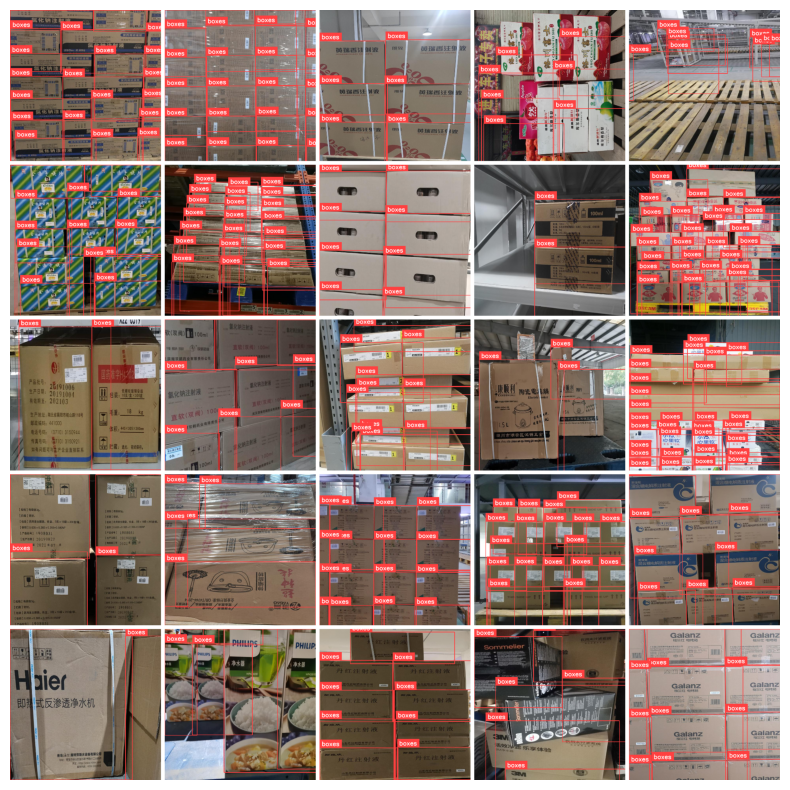

In [ ]:
GRID_SIZE = 5


annotated_images = []
for i in range(GRID_SIZE * GRID_SIZE):
    _, image, annotations = ds_train[i]
    annotated_image = annotate(image, annotations, ds_train.classes)
    annotated_images.append(annotated_image)

grid = sv.create_tiles(
    annotated_images,
    grid_size=(GRID_SIZE, GRID_SIZE),
    single_tile_size=(400, 400),
    tile_padding_color=sv.Color.WHITE,
    tile_margin_color=sv.Color.WHITE
)
sv.plot_image(grid, size=(10, 10))

# Fine-tune model

## Pre-process data

## load processor

In [ ]:
IMAGE_SIZE = 480
CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"
processor = AutoImageProcessor.from_pretrained(
    CHECKPOINT,
    do_resize=True,
    size={"width": IMAGE_SIZE, "height": IMAGE_SIZE},
)

## prepare dataset

In [ ]:
# A is albumentations

train_augmentation_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=25,
        min_visibility=0.3  # Optionally, filter out partially visible bboxes
    ),
)

valid_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=1,
        min_visibility=0.3  # Optionally, filter out partially visible bboxes
    ),
)


### visualize some augmented images

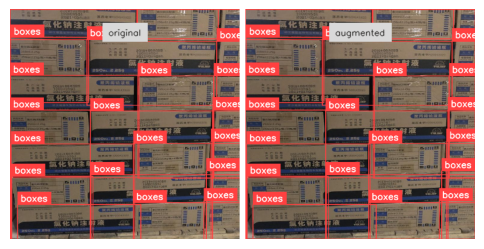

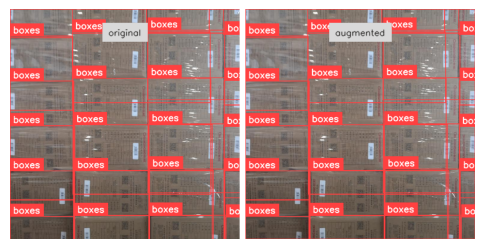

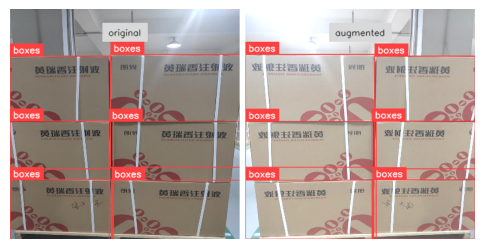

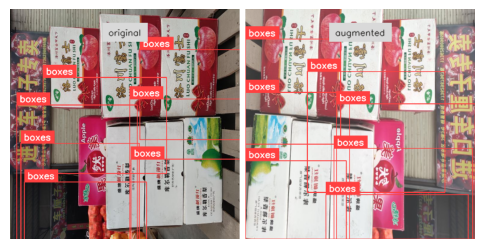

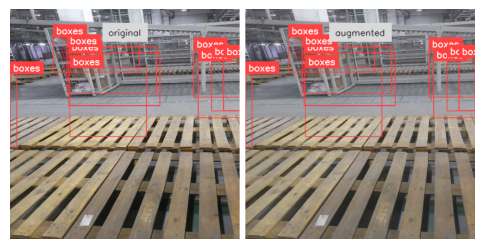

In [ ]:
IMAGE_COUNT = 5

for i in range(IMAGE_COUNT):
    _, image, annotations = ds_train[i]

    output = train_augmentation_and_transform(
        image=image,
        bboxes=annotations.xyxy,
        category=annotations.class_id
    )

    augmented_image = output["image"]
    augmented_annotations = replace(
        annotations,
        xyxy=np.array(output["bboxes"]),
        class_id=np.array(output["category"])
    )

    annotated_images = [
        annotate(image, annotations, ds_train.classes),
        annotate(augmented_image, augmented_annotations, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['original', 'augmented'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))

In [ ]:
class PyTorchDetectionDataset(Dataset):
    def __init__(self, dataset: sv.DetectionDataset,
                 processor,
                 transform: A.Compose = None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    @staticmethod
    def annotations_as_coco(image_id, categories, boxes):
        annotations = []
        for category, bbox in zip(categories, boxes):
            x1, y1, x2, y2 = bbox
            formatted_annotation = {
                "image_id": image_id,
                "category_id": category,
                "bbox": [x1, y1, x2, y2],
                "iscrowd": 0,
                "area": (x2 - x1) * (y2 - y1),
            }
            annotations.append(formatted_annotation)

        return {
            "image_id": image_id,
            "annotations": annotations,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        _, image, annotations = self.dataset[idx]

        # Convert image to RGB numpy array
        image = image[:, :, ::-1]
        boxes = annotations.xyxy
        categories = annotations.class_id

        if self.transform:
            transformed = self.transform(
                image=image,
                bboxes=boxes,
                category=categories
            )
            image = transformed["image"]
            boxes = transformed["bboxes"]
            categories = transformed["category"]


        formatted_annotations = self.annotations_as_coco(
            image_id=idx, categories=categories, boxes=boxes)
        result = self.processor(
            images=image, annotations=formatted_annotations, return_tensors="pt")

        # Image processor expands batch dimension, lets squeeze it
        result = {k: v[0] for k, v in result.items()}

        return result

Now you can combine the image and annotation transformations to use on a batch of examples:

In [ ]:
pytorch_dataset_train = PyTorchDetectionDataset(
    ds_train, processor, transform=train_augmentation_and_transform)
pytorch_dataset_valid = PyTorchDetectionDataset(
    ds_valid, processor, transform=valid_transform)
pytorch_dataset_test = PyTorchDetectionDataset(
    ds_test, processor, transform=valid_transform)

# pytorch_dataset_train[15]

In [ ]:
pytorch_dataset_train[15]['pixel_values'].shape

torch.Size([3, 480, 480])

## prepare function to compute mAP

In [ ]:
id2label = {id: label for id, label in enumerate(ds_train.classes)}
label2id = {label: id for id, label in enumerate(ds_train.classes)}


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


class MAPEvaluator:

    def __init__(self, image_processor, threshold=0.00, id2label=None):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """Collect image sizes across the dataset as list of tensors with shape [batch_size, 2]."""
        image_sizes = []
        for batch in targets:
            batch_image_sizes = torch.tensor(np.array([x["size"] for x in batch]))
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, (height, width) in zip(target_batch, image_size_batch):
                boxes = target["boxes"]
                boxes = sv.xcycwh_to_xyxy(boxes)
                boxes = boxes * np.array([width, height, width, height])
                boxes = torch.tensor(boxes)
                labels = torch.tensor(target["class_labels"])
                post_processed_targets.append({"boxes": boxes, "labels": labels})
        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
            post_processed_output = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):

        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        # Replace list of per class metrics with separate metric for each class
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics

eval_compute_metrics_fn = MAPEvaluator(image_processor=processor, threshold=0.01, id2label=id2label)

## Evaluate zero-shot model

### single random image

In [ ]:
n = 50
image_name, np_image, annotations = ds_train[n]
print(image_name)
print(np_image.shape)
inputs = processor(np_image, return_tensors="pt").to(DEVICE)
print(inputs['pixel_values'].shape)
with torch.no_grad():
    outputs = model(**inputs)

w, h = (768, 768)
results = processor.post_process_object_detection(
    outputs, target_sizes=[(h, w)], threshold=0.3)

ft-scd-coco-dataset/train/LSCD_213.jpg
(768, 768, 3)
torch.Size([1, 3, 640, 640])


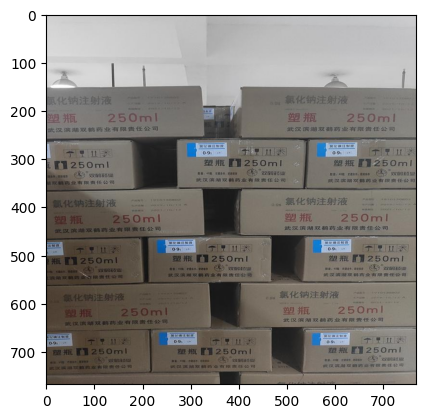

In [ ]:
image = Image.open(image_name)
plt.imshow(image);

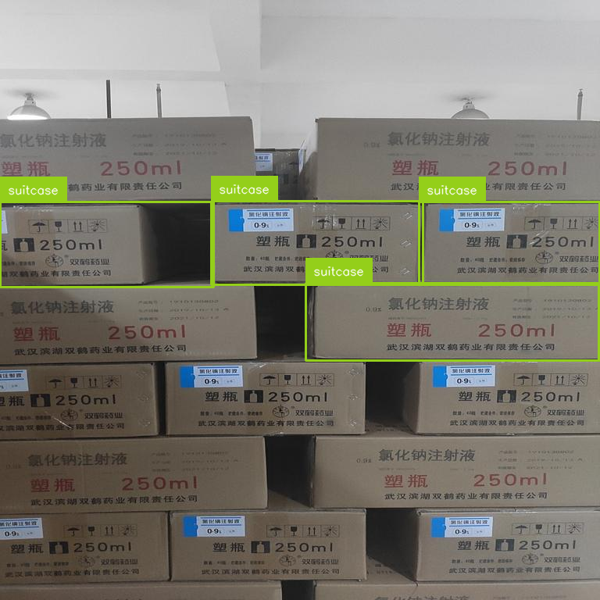

In [ ]:
detections = sv.Detections.from_transformers(results[0])
labels = [
    model.config.id2label[class_id]
    for class_id
    in detections.class_id
]

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(annotated_image, detections)
annotated_image = sv.LabelAnnotator().annotate(annotated_image, detections, labels=labels)
annotated_image.thumbnail((600, 600))
annotated_image

In [ ]:
labels

['refrigerator', 'refrigerator', 'refrigerator', 'refrigerator']

In [ ]:
detections

Detections(xyxy=array([[ 1.8617249e-01, -8.7380219e-01,  7.6817834e+02,  7.6711145e+02],
       [ 2.7184296e-01,  5.4505920e-01,  3.8783817e+02,  7.6850665e+02],
       [ 3.5421652e+02,  1.1228714e+00,  7.6737952e+02,  5.4157312e+02],
       [ 3.5517822e+02, -7.2720337e-01,  7.6777417e+02,  7.6725714e+02]],
      dtype=float32), mask=None, confidence=array([0.5752207 , 0.50466967, 0.4293996 , 0.30602908], dtype=float32), class_id=array([72, 72, 72, 72]), tracker_id=None, data={})

### evaluate test images

In [ ]:
targets = []
predictions = []

for i in range(len(ds_test)):
    print(i)
    path, source_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0])

    targets.append(annotations)
    predictions.append(detections)
    break

0


In [ ]:
predictions, targets

([Detections(xyxy=array([[ 7.7133179e-02, -1.7237091e+00,  7.6806830e+02,  7.6624353e+02]],
        dtype=float32), mask=None, confidence=array([0.66440624], dtype=float32), class_id=array([72]), tracker_id=None, data={})],
 [Detections(xyxy=array([[ 343,  349, 1068, 1114],
         [  25,  336,  381, 1070],
         [   0,    0,  767,  365],
         [ 718,  363, 1485,  810],
         [ 677,  409, 1444, 1067]]), mask=None, confidence=None, class_id=array([0, 0, 0, 0, 0]), tracker_id=None, data={})])

In [ ]:
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.00
map50: 0.00
map75: 0.00


In [ ]:
targets[:5]

[Detections(xyxy=array([[ 343,  349, 1068, 1114],
        [  25,  336,  381, 1070],
        [   0,    0,  767,  365],
        [ 718,  363, 1485,  810],
        [ 677,  409, 1444, 1067]]), mask=None, confidence=None, class_id=array([0, 0, 0, 0, 0]), tracker_id=None, data={}),
 Detections(xyxy=array([[  38,  362,  456, 1070],
        [ 433,    4, 1200,  368],
        [ 425,  362, 1192, 1063],
        [  42,    0,  480,  360]]), mask=None, confidence=None, class_id=array([0, 0, 0, 0]), tracker_id=None, data={}),
 Detections(xyxy=array([[ 134,  220,  466,  672],
        [ 359,  154,  917,  598],
        [ 320,  510,  786, 1193],
        [ 452,  499, 1066, 1167],
        [ 580,  484, 1327, 1136],
        [ 704,  482, 1471, 1113],
        [ 563,    0, 1330,   89]]), mask=None, confidence=None, class_id=array([0, 0, 0, 0, 0, 0, 0]), tracker_id=None, data={}),
 Detections(xyxy=array([[ 405,   83, 1072,  332],
        [ 399,  232, 1096,  623],
        [ 402,  358, 1056,  876],
        [ 395,  4

In [ ]:
predictions[0]

Detections(xyxy=array([[ 2.0086670e-01, -1.7419052e+00,  7.6819281e+02,  7.6621637e+02],
       [ 6.4287878e+02,  6.7458084e+01,  7.6797095e+02,  1.8183342e+02]],
      dtype=float32), mask=None, confidence=array([0.4928568, 0.3388504], dtype=float32), class_id=array([72, 54]), tracker_id=None, data={})

## train model

In [ ]:
model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
    anchor_image_size=None,
    ignore_mismatched_sizes=True,
)

Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd_coco_o365 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=f"{image_directory_path.replace(' ', '-')}-finetune",
    num_train_epochs=20,
    max_grad_norm=0.1,
    learning_rate=5e-5,
    eval_on_start=True,
    warmup_steps=300,
    per_device_train_batch_size=16,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="steps",   # Changed from "epoch" to "steps"
    eval_steps=100,          # Evaluate every 100 steps
    save_strategy="steps",   # Changed from "epoch" to "steps"
    save_steps=1000,          # Save every 100 steps
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    disable_tqdm=True
)



In [ ]:
def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    return data

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=pytorch_dataset_train,
    eval_dataset=pytorch_dataset_valid,
    tokenizer=processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)



In [ ]:
trainer.train()

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


{'eval_loss': 7.44833517074585, 'eval_map': 0.771, 'eval_map_50': 0.8732, 'eval_map_75': 0.8103, 'eval_map_small': 0.5055, 'eval_map_medium': 0.5537, 'eval_map_large': 0.7934, 'eval_mar_1': 0.0795, 'eval_mar_10': 0.6014, 'eval_mar_100': 0.881, 'eval_mar_small': 0.85, 'eval_mar_medium': 0.767, 'eval_mar_large': 0.8889, 'eval_map_background': -1.0, 'eval_mar_100_background': -1.0, 'eval_map_boxes': 0.771, 'eval_mar_100_boxes': 0.881, 'eval_runtime': 9.942, 'eval_samples_per_second': 15.087, 'eval_steps_per_second': 1.911, 'epoch': 0}
{'eval_loss': 7.42629861831665, 'eval_map': 0.773, 'eval_map_50': 0.8698, 'eval_map_75': 0.8154, 'eval_map_small': 0.3739, 'eval_map_medium': 0.5518, 'eval_map_large': 0.7961, 'eval_mar_1': 0.0817, 'eval_mar_10': 0.5988, 'eval_mar_100': 0.8851, 'eval_mar_small': 0.8, 'eval_mar_medium': 0.7709, 'eval_mar_large': 0.8931, 'eval_map_background': -1.0, 'eval_mar_100_background': -1.0, 'eval_map_boxes': 0.773, 'eval_mar_100_boxes': 0.8851, 'eval_runtime': 11.0231,

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


{'eval_loss': 8.000312805175781, 'eval_map': 0.7546, 'eval_map_50': 0.8637, 'eval_map_75': 0.7922, 'eval_map_small': 0.4753, 'eval_map_medium': 0.5488, 'eval_map_large': 0.7725, 'eval_mar_1': 0.0779, 'eval_mar_10': 0.5908, 'eval_mar_100': 0.873, 'eval_mar_small': 0.85, 'eval_mar_medium': 0.7466, 'eval_mar_large': 0.8817, 'eval_map_background': -1.0, 'eval_mar_100_background': -1.0, 'eval_map_boxes': 0.7546, 'eval_mar_100_boxes': 0.873, 'eval_runtime': 10.2248, 'eval_samples_per_second': 14.67, 'eval_steps_per_second': 1.858, 'epoch': 2.7363184079601988}
{'eval_loss': 8.445027351379395, 'eval_map': 0.7191, 'eval_map_50': 0.84, 'eval_map_75': 0.7532, 'eval_map_small': 0.4168, 'eval_map_medium': 0.5685, 'eval_map_large': 0.7339, 'eval_mar_1': 0.076, 'eval_mar_10': 0.5661, 'eval_mar_100': 0.8675, 'eval_mar_small': 0.85, 'eval_mar_medium': 0.7359, 'eval_mar_large': 0.8769, 'eval_map_background': -1.0, 'eval_mar_100_background': -1.0, 'eval_map_boxes': 0.7191, 'eval_mar_100_boxes': 0.8675, '

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


{'eval_loss': 7.049482345581055, 'eval_map': 0.7841, 'eval_map_50': 0.8864, 'eval_map_75': 0.8315, 'eval_map_small': 0.5044, 'eval_map_medium': 0.5661, 'eval_map_large': 0.7996, 'eval_mar_1': 0.0821, 'eval_mar_10': 0.6009, 'eval_mar_100': 0.8836, 'eval_mar_small': 0.85, 'eval_mar_medium': 0.7301, 'eval_mar_large': 0.8943, 'eval_map_background': -1.0, 'eval_mar_100_background': -1.0, 'eval_map_boxes': 0.7841, 'eval_mar_100_boxes': 0.8836, 'eval_runtime': 11.114, 'eval_samples_per_second': 13.497, 'eval_steps_per_second': 1.71, 'epoch': 5.223880597014926}
{'eval_loss': 7.429203987121582, 'eval_map': 0.7846, 'eval_map_50': 0.883, 'eval_map_75': 0.8227, 'eval_map_small': 0.3604, 'eval_map_medium': 0.5765, 'eval_map_large': 0.8013, 'eval_mar_1': 0.0802, 'eval_mar_10': 0.6037, 'eval_mar_100': 0.8858, 'eval_mar_small': 0.85, 'eval_mar_medium': 0.765, 'eval_mar_large': 0.8942, 'eval_map_background': -1.0, 'eval_mar_100_background': -1.0, 'eval_map_boxes': 0.7846, 'eval_mar_100_boxes': 0.8858, 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


{'eval_loss': 7.399501800537109, 'eval_map': 0.7758, 'eval_map_50': 0.8816, 'eval_map_75': 0.8161, 'eval_map_small': 0.2861, 'eval_map_medium': 0.578, 'eval_map_large': 0.7908, 'eval_mar_1': 0.0812, 'eval_mar_10': 0.5963, 'eval_mar_100': 0.8768, 'eval_mar_small': 0.8, 'eval_mar_medium': 0.7243, 'eval_mar_large': 0.8878, 'eval_map_background': -1.0, 'eval_mar_100_background': -1.0, 'eval_map_boxes': 0.7758, 'eval_mar_100_boxes': 0.8768, 'eval_runtime': 9.9739, 'eval_samples_per_second': 15.039, 'eval_steps_per_second': 1.905, 'epoch': 7.711442786069652}
{'eval_loss': 7.298880100250244, 'eval_map': 0.7804, 'eval_map_50': 0.8863, 'eval_map_75': 0.822, 'eval_map_small': 0.3587, 'eval_map_medium': 0.5761, 'eval_map_large': 0.7984, 'eval_mar_1': 0.0809, 'eval_mar_10': 0.6056, 'eval_mar_100': 0.8837, 'eval_mar_small': 0.8, 'eval_mar_medium': 0.7573, 'eval_mar_large': 0.8926, 'eval_map_background': -1.0, 'eval_mar_100_background': -1.0, 'eval_map_boxes': 0.7804, 'eval_mar_100_boxes': 0.8837, '

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


{'eval_loss': 7.059729099273682, 'eval_map': 0.7871, 'eval_map_50': 0.896, 'eval_map_75': 0.825, 'eval_map_small': 0.4919, 'eval_map_medium': 0.5901, 'eval_map_large': 0.8022, 'eval_mar_1': 0.0803, 'eval_mar_10': 0.6046, 'eval_mar_100': 0.8851, 'eval_mar_small': 0.75, 'eval_mar_medium': 0.765, 'eval_mar_large': 0.8936, 'eval_map_background': -1.0, 'eval_mar_100_background': -1.0, 'eval_map_boxes': 0.7871, 'eval_mar_100_boxes': 0.8851, 'eval_runtime': 10.5622, 'eval_samples_per_second': 14.202, 'eval_steps_per_second': 1.799, 'epoch': 10.199004975124378}
{'eval_loss': 7.152550220489502, 'eval_map': 0.7966, 'eval_map_50': 0.898, 'eval_map_75': 0.8345, 'eval_map_small': 0.2097, 'eval_map_medium': 0.5911, 'eval_map_large': 0.8113, 'eval_mar_1': 0.0822, 'eval_mar_10': 0.6116, 'eval_mar_100': 0.8887, 'eval_mar_small': 0.55, 'eval_mar_medium': 0.7583, 'eval_mar_large': 0.8981, 'eval_map_background': -1.0, 'eval_mar_100_background': -1.0, 'eval_map_boxes': 0.7966, 'eval_mar_100_boxes': 0.8887,

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


{'eval_loss': 7.061305522918701, 'eval_map': 0.7951, 'eval_map_50': 0.9036, 'eval_map_75': 0.8353, 'eval_map_small': 0.3668, 'eval_map_medium': 0.5843, 'eval_map_large': 0.8103, 'eval_mar_1': 0.0826, 'eval_mar_10': 0.6125, 'eval_mar_100': 0.8849, 'eval_mar_small': 0.75, 'eval_mar_medium': 0.7524, 'eval_mar_large': 0.8944, 'eval_map_background': -1.0, 'eval_mar_100_background': -1.0, 'eval_map_boxes': 0.7951, 'eval_mar_100_boxes': 0.8849, 'eval_runtime': 9.9728, 'eval_samples_per_second': 15.041, 'eval_steps_per_second': 1.905, 'epoch': 12.686567164179104}
{'eval_loss': 7.612856388092041, 'eval_map': 0.7723, 'eval_map_50': 0.8891, 'eval_map_75': 0.8177, 'eval_map_small': 0.4505, 'eval_map_medium': 0.5852, 'eval_map_large': 0.7865, 'eval_mar_1': 0.08, 'eval_mar_10': 0.5965, 'eval_mar_100': 0.8772, 'eval_mar_small': 0.7, 'eval_mar_medium': 0.7398, 'eval_mar_large': 0.8872, 'eval_map_background': -1.0, 'eval_mar_100_background': -1.0, 'eval_map_boxes': 0.7723, 'eval_mar_100_boxes': 0.8772,

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


{'eval_loss': 7.299567222595215, 'eval_map': 0.787, 'eval_map_50': 0.9026, 'eval_map_75': 0.8245, 'eval_map_small': 0.3668, 'eval_map_medium': 0.5758, 'eval_map_large': 0.8031, 'eval_mar_1': 0.0816, 'eval_mar_10': 0.6112, 'eval_mar_100': 0.8824, 'eval_mar_small': 0.75, 'eval_mar_medium': 0.7583, 'eval_mar_large': 0.8911, 'eval_map_background': -1.0, 'eval_mar_100_background': -1.0, 'eval_map_boxes': 0.787, 'eval_mar_100_boxes': 0.8824, 'eval_runtime': 11.0305, 'eval_samples_per_second': 13.599, 'eval_steps_per_second': 1.722, 'epoch': 15.17412935323383}
{'eval_loss': 7.308759689331055, 'eval_map': 0.7886, 'eval_map_50': 0.9008, 'eval_map_75': 0.8258, 'eval_map_small': 0.4505, 'eval_map_medium': 0.5844, 'eval_map_large': 0.8031, 'eval_mar_1': 0.0829, 'eval_mar_10': 0.6108, 'eval_mar_100': 0.8825, 'eval_mar_small': 0.7, 'eval_mar_medium': 0.7524, 'eval_mar_large': 0.892, 'eval_map_background': -1.0, 'eval_mar_100_background': -1.0, 'eval_map_boxes': 0.7886, 'eval_mar_100_boxes': 0.8825, 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


{'eval_loss': 7.081990718841553, 'eval_map': 0.7992, 'eval_map_50': 0.9076, 'eval_map_75': 0.836, 'eval_map_small': 0.3337, 'eval_map_medium': 0.5959, 'eval_map_large': 0.8136, 'eval_mar_1': 0.0827, 'eval_mar_10': 0.6187, 'eval_mar_100': 0.8851, 'eval_mar_small': 0.7, 'eval_mar_medium': 0.7573, 'eval_mar_large': 0.8946, 'eval_map_background': -1.0, 'eval_mar_100_background': -1.0, 'eval_map_boxes': 0.7992, 'eval_mar_100_boxes': 0.8851, 'eval_runtime': 10.239, 'eval_samples_per_second': 14.65, 'eval_steps_per_second': 1.856, 'epoch': 17.66169154228856}
{'eval_loss': 7.249711990356445, 'eval_map': 0.7932, 'eval_map_50': 0.9034, 'eval_map_75': 0.8304, 'eval_map_small': 0.4505, 'eval_map_medium': 0.595, 'eval_map_large': 0.8076, 'eval_mar_1': 0.0825, 'eval_mar_10': 0.6132, 'eval_mar_100': 0.8841, 'eval_mar_small': 0.7, 'eval_mar_medium': 0.7534, 'eval_mar_large': 0.8934, 'eval_map_background': -1.0, 'eval_mar_100_background': -1.0, 'eval_map_boxes': 0.7932, 'eval_mar_100_boxes': 0.8841, 'e

There were missing keys in the checkpoint model loaded: ['class_embed.0.weight', 'class_embed.0.bias', 'class_embed.1.weight', 'class_embed.1.bias', 'class_embed.2.weight', 'class_embed.2.bias', 'class_embed.3.weight', 'class_embed.3.bias', 'class_embed.4.weight', 'class_embed.4.bias', 'class_embed.5.weight', 'class_embed.5.bias', 'bbox_embed.0.layers.0.weight', 'bbox_embed.0.layers.0.bias', 'bbox_embed.0.layers.1.weight', 'bbox_embed.0.layers.1.bias', 'bbox_embed.0.layers.2.weight', 'bbox_embed.0.layers.2.bias', 'bbox_embed.1.layers.0.weight', 'bbox_embed.1.layers.0.bias', 'bbox_embed.1.layers.1.weight', 'bbox_embed.1.layers.1.bias', 'bbox_embed.1.layers.2.weight', 'bbox_embed.1.layers.2.bias', 'bbox_embed.2.layers.0.weight', 'bbox_embed.2.layers.0.bias', 'bbox_embed.2.layers.1.weight', 'bbox_embed.2.layers.1.bias', 'bbox_embed.2.layers.2.weight', 'bbox_embed.2.layers.2.bias', 'bbox_embed.3.layers.0.weight', 'bbox_embed.3.layers.0.bias', 'bbox_embed.3.layers.1.weight', 'bbox_embed.3.l

{'train_runtime': 7950.4167, 'train_samples_per_second': 16.18, 'train_steps_per_second': 1.011, 'train_loss': 12.03462620066173, 'epoch': 20.0}


TrainOutput(global_step=8040, training_loss=12.03462620066173, metrics={'train_runtime': 7950.4167, 'train_samples_per_second': 16.18, 'train_steps_per_second': 1.011, 'train_loss': 12.03462620066173, 'epoch': 20.0})

# Evaluate

In [5]:
local_model_path = 'ft-scd-coco-dataset/train-finetune/checkpoint-8040'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForObjectDetection.from_pretrained(local_model_path ).to(DEVICE)
processor = AutoImageProcessor.from_pretrained(local_model_path)

In [6]:
targets = []
predictions = []

for i in range(len(ds_test)):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0])

    targets.append(annotations)
    predictions.append(detections)

In [7]:
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.08
map50: 0.20
map75: 0.05


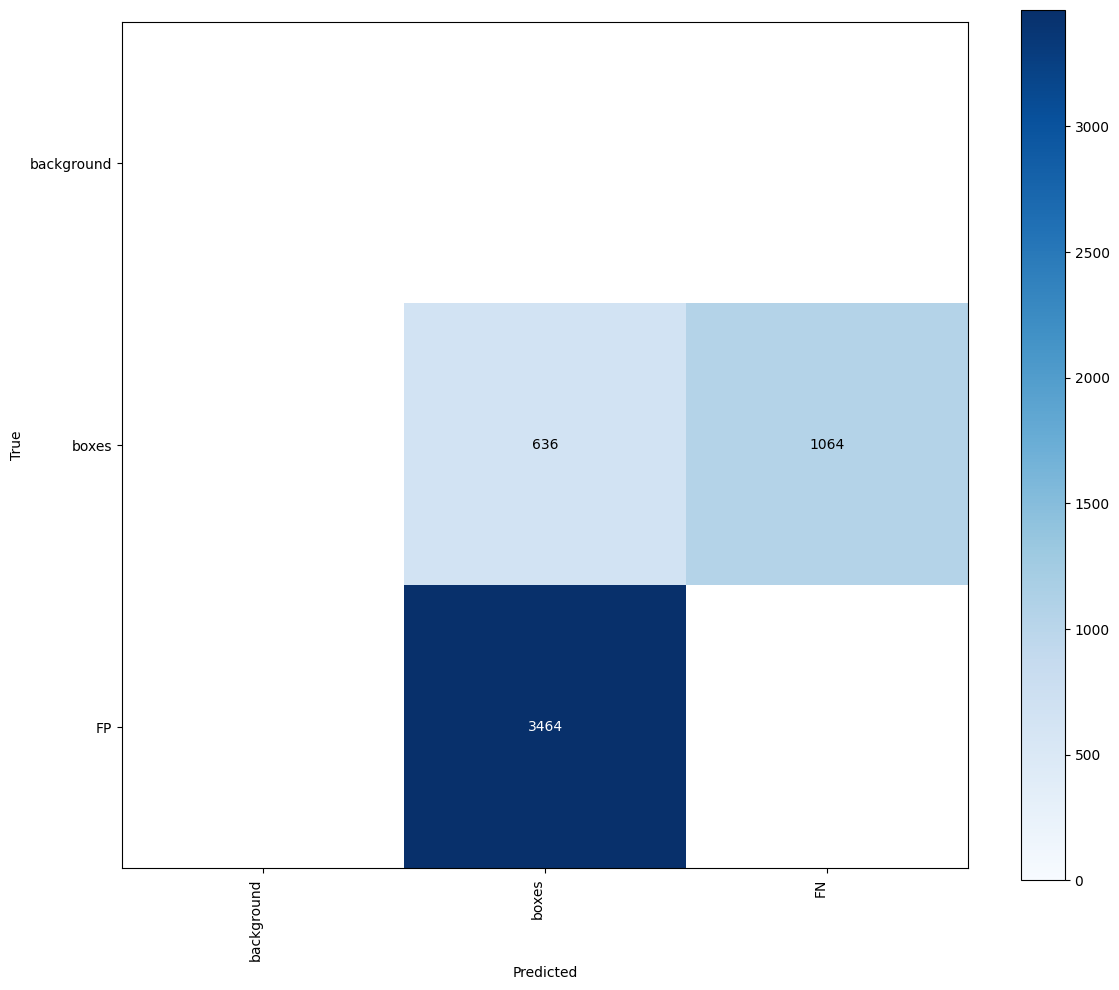

In [8]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds_test.classes
)

_ = confusion_matrix.plot()

In [17]:
image_directory_path = "ft-scd-coco-dataset/test"
annotations_path=f"{image_directory_path}/annotations.coco.json"
annot_test = json.load(open(annotations_path))
annot_test_df = pd.DataFrame(annot_test['annotations'])

len(annot_test_df), annot_test_df.id.nunique()

(1700, 1700)

The model was fine-tuned for 40 epochs. After fine-tuning the model was able to correctly detect 636 out of a total of 1700 carton segments. The number of False positives is 3,464, False negatives: 1064.  
The model has failed to achieve adequate scores. Maybe we can raise its accuracy by fine-tuning parameters, but we are going to fine-tune/test other candidates first.

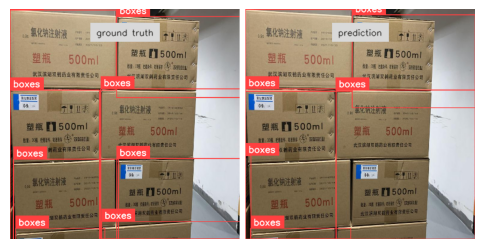

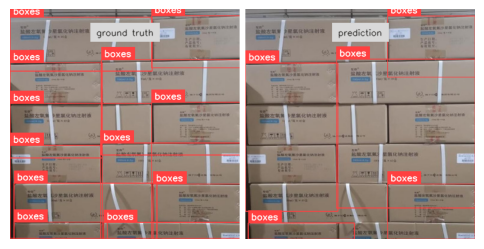

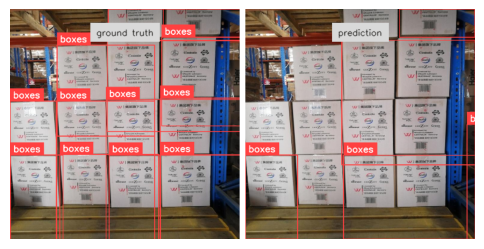

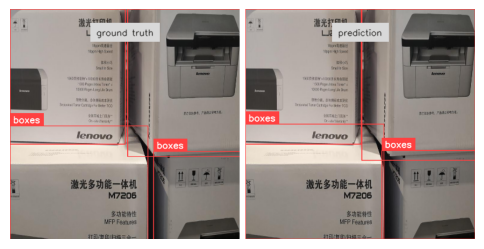

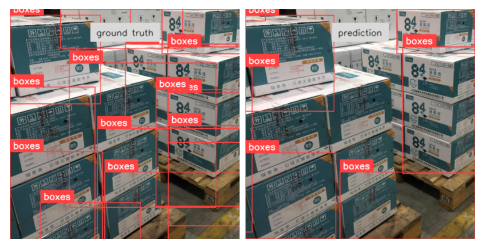

In [16]:
IMAGE_COUNT = 5

def annotate(image, annotations, classes):
    labels = [
        classes[class_id]
        for class_id
        in annotations.class_id
    ]

    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_scale=1, text_thickness=2)

    annotated_image = image.copy()
    annotated_image = bounding_box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels=labels)
    return annotated_image

for i in range(IMAGE_COUNT):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.1)

    annotated_images = [
        annotate(sourece_image, annotations, ds_train.classes),
        annotate(sourece_image, detections, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['ground truth', 'prediction'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))